# Preamble

## Packages and functions

In [3]:
%load_ext autoreload

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn import set_config
set_config(display='diagram')

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

import shap

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_validate, GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

import pickle

import gc

import time
from contextlib import contextmanager

from tqdm import tqdm
tqdm.pandas()

## Personal functions

In [5]:
from utils.visualization import *
from utils.feature_engineering import *
from utils.modelling import *

# Data assembly

In [4]:
# # Assemble full data
# df = home_credit_dataframe()

Process train and test application - done in 53s
Process bureau and bureau_balance - done in 121s
Process previous_applications - done in 116s
Process POS_CASH_balance - done in 51s
Process installments_payments - done in 23s
Process credit_card_balance - done in 32s


# Data export

In [5]:
# # Save full data
# df.to_csv('data/full_data.csv')

# Data import

In [5]:
# Read full data
df = reduce_memory_usage(
    pd.read_csv(
        'data/full_data.csv',
        index_col='SK_ID_CURR'
    )
)
# Reducing again the memory is necessary due to the missing data
# in the integer features, because a NaN makes the variable of type float64

# Data overview

In [8]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 100002 to 456250
Data columns (total 600 columns):
 #    Column                                                               Dtype  
---   ------                                                               -----  
 0    TARGET                                                               float16
 1    NAME_CONTRACT_TYPE                                                   object 
 2    CODE_GENDER                                                          object 
 3    FLAG_OWN_CAR                                                         object 
 4    FLAG_OWN_REALTY                                                      object 
 5    CNT_CHILDREN                                                         int8   
 6    AMT_INCOME_TOTAL                                                     float32
 7    AMT_CREDIT                                                           float32
 8    AMT_ANNUITY                                    

In [9]:
df.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash_loans           M            N   
100003         0.0         Cash_loans           F            N   
100004         0.0    Revolving_loans           M            Y   
100006         0.0         Cash_loans           F            N   
100007         0.0         Cash_loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  ...  \
SK_ID_CURR                                ...   
100002          24700.5         351000.0  ...   
100003          35698.5        1129500.0  ...   
100004           6750.0         135000.0  ...   
100006          29686.5         297000.0  ...   
100007          21865.5         513000.0  ...   

           CC_CNT_INSTALMENT_MATURE_CUM_mean CC_SK_DPD_sum CC_SK_DPD_max  \
SK_ID_CURR                                                                 
100002                                   NaN           NaN           NaN   
100003                                   NaN           NaN           NaN   
100004                                   NaN           NaN           NaN   
100006                                   0.0           0.0           0.0   
100007                                   NaN           NaN           NaN   

           CC_SK_DPD_min CC_SK_DPD_mean  CC_SK_DPD_DEF_sum  CC_SK_DPD_DEF_max  \
SK_ID_CURR                                                                      
100002               NaN            NaN                NaN                NaN   
100003               NaN            NaN                NaN                NaN   
100004               NaN            NaN                NaN                NaN   
100006               0.0            0.0                0.0                0.0   
100007               NaN            NaN                NaN                NaN   

            CC_SK_DPD_DEF_min  CC_SK_DPD_DEF_mean  CC_COUNT  
SK_ID_CURR                                                   
100002                    NaN                 NaN       NaN  
100003                    NaN                 NaN       NaN  
100004                    NaN                 NaN       NaN  
100006                    0.0                 0.0       6.0  
100007                    NaN                 NaN       NaN  

[5 rows x 600 columns]

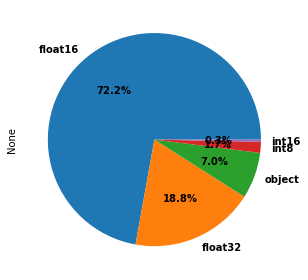

In [10]:
df.dtypes.value_counts().plot.pie(
    autopct='%.1f%%',
    textprops=dict(weight='bold')
)
plt.tight_layout()
plt.show()

In [11]:
df.select_dtypes(include='object').columns.to_series().reset_index(drop=True)

0             NAME_CONTRACT_TYPE
1                    CODE_GENDER
2                   FLAG_OWN_CAR
3                FLAG_OWN_REALTY
4                NAME_TYPE_SUITE
5               NAME_INCOME_TYPE
6            NAME_EDUCATION_TYPE
7             NAME_FAMILY_STATUS
8              NAME_HOUSING_TYPE
9                     FLAG_MOBIL
10                FLAG_EMP_PHONE
11               FLAG_WORK_PHONE
12              FLAG_CONT_MOBILE
13                    FLAG_PHONE
14                    FLAG_EMAIL
15               OCCUPATION_TYPE
16    WEEKDAY_APPR_PROCESS_START
17             ORGANIZATION_TYPE
18            FONDKAPREMONT_MODE
19                HOUSETYPE_MODE
20            WALLSMATERIAL_MODE
21           EMERGENCYSTATE_MODE
22               FLAG_DOCUMENT_2
23               FLAG_DOCUMENT_3
24               FLAG_DOCUMENT_4
25               FLAG_DOCUMENT_5
26               FLAG_DOCUMENT_6
27               FLAG_DOCUMENT_7
28               FLAG_DOCUMENT_8
29               FLAG_DOCUMENT_9
30        

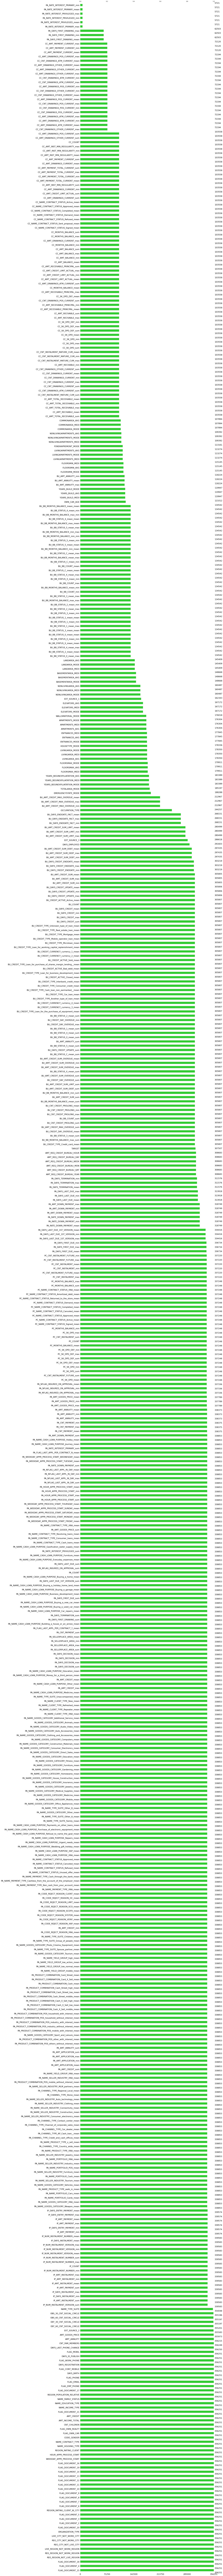

In [12]:
msno.bar(
    df,
    sort='descending',
    color='limegreen'
)
plt.tight_layout()
plt.show()

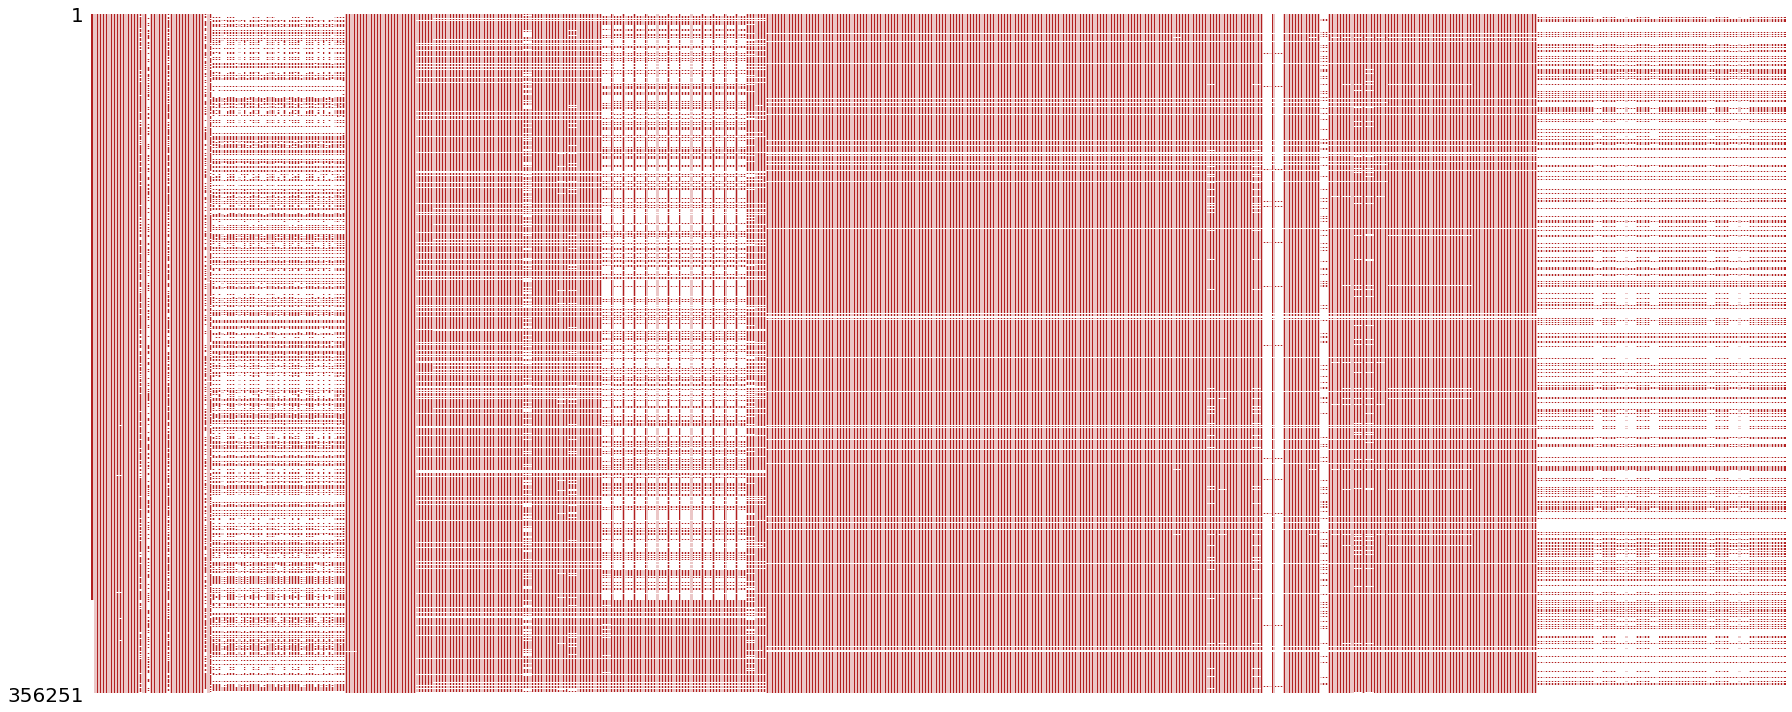

In [13]:
msno.matrix(
    df,
    sparkline=False,
    color=(.7, .13, .13)
)
plt.tight_layout()
plt.show()

# Data preprocessing

## Skewed class distribution

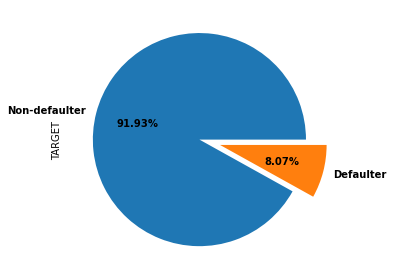

In [14]:
# Original skewed class distribution with all features
df['TARGET'].value_counts().plot.pie(
    autopct='%.2f%%',
    labels=['Non-defaulter', 'Defaulter'],
    textprops=dict(weight='bold'),
    explode=[0, .2]
)
plt.tight_layout()
plt.show()

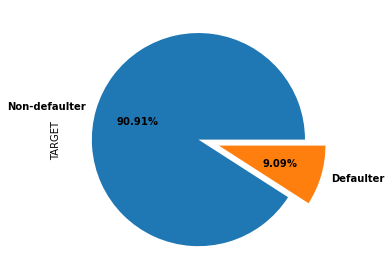

In [15]:
# Skewed class distribution for data with all features filled
df[df.notna().all(1)]['TARGET'].value_counts().plot.pie(
    autopct='%.2f%%',
    labels=['Non-defaulter', 'Defaulter'],
    textprops=dict(weight='bold'),
    explode=[0, .2]
)
plt.tight_layout()
plt.show()

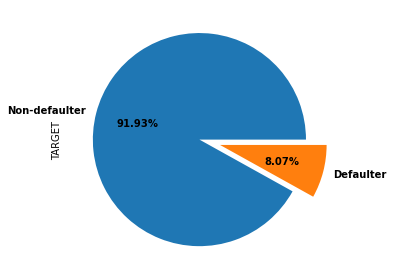

In [16]:
# Skewed class distribution for features with no missing data plus target feature
df[['TARGET'] + df.columns[df.notna().all()].tolist()]['TARGET'].value_counts().plot.pie(
    autopct='%.2f%%',
    labels=['Non-defaulter', 'Defaulter'],
    textprops=dict(weight='bold'),
    explode=[0, .2]
)
plt.tight_layout()
plt.show()

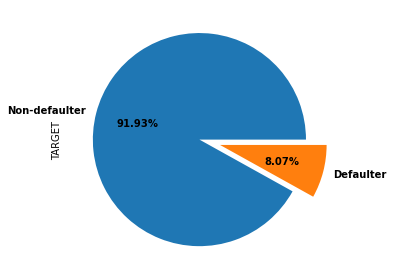

In [17]:
# Skewed class distribution with features 80% filled
df[df.columns[df.notna().mean().ge(.8)]]['TARGET'].value_counts().plot.pie(
    autopct='%.2f%%',
    labels=['Non-defaulter', 'Defaulter'],
    textprops=dict(weight='bold'),
    explode=[0, .2]
)
plt.tight_layout()
plt.show()

In [6]:
fill_rate = .6

print(
    f'Number of 100% filled features: {len(df.columns[df.notna().all()])}\n'
    f'Number of {fill_rate * 100}% filled features: {len(df.columns[df.notna().mean().ge(fill_rate)])}'
)
# Keep those features 80% filled
dg = df[df.columns[df.notna().mean().ge(fill_rate)]]
# Keep those samples with the 80% filled features full with the exception of the target
dh = dg[dg.drop(columns='TARGET').notna().all(1)]

# Si l'on fixe les 400 colonnes, pourcantage de la population avec ces 400 remplies à 100 %
# Garder ensemble variables population 80 % remplie -> imputer
# Se limiter aux 400 features, regarder celles 100 % remplies

Number of 100% filled features: 52
Number of 60.0% filled features: 412


In [7]:
dh.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139723 entries, 100002 to 456250
Data columns (total 412 columns):
 #    Column                                                               Dtype  
---   ------                                                               -----  
 0    TARGET                                                               float16
 1    NAME_CONTRACT_TYPE                                                   object 
 2    CODE_GENDER                                                          object 
 3    FLAG_OWN_CAR                                                         object 
 4    FLAG_OWN_REALTY                                                      object 
 5    CNT_CHILDREN                                                         int8   
 6    AMT_INCOME_TOTAL                                                     float32
 7    AMT_CREDIT                                                           float32
 8    AMT_ANNUITY                                    

In [8]:
dh.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash_loans           M            N   
100004         0.0    Revolving_loans           M            Y   
100008         0.0         Cash_loans           M            N   
100009         0.0         Cash_loans           F            Y   
100010         0.0         Cash_loans           M            Y   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100004                   Y             0           67500.0    135000.0   
100008                   Y             0           99000.0    490495.5   
100009                   Y             1          171000.0   1560726.0   
100010                   Y             0          360000.0   1530000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  ... IP_AMT_PAYMENT_max  \
SK_ID_CURR                                ...                      
100002          24700.5         351000.0  ...       53093.746094   
100004           6750.0         135000.0  ...       10573.964844   
100008          27517.5         454500.0  ...      432218.281250   
100009          41301.0        1395000.0  ...       17341.605469   
100010          42075.0        1530000.0  ...       27463.410156   

           IP_AMT_PAYMENT_min IP_AMT_PAYMENT_mean IP_DAYS_INSTALMENT_max  \
SK_ID_CURR                                                                 
100002            9251.775391        11559.247070                  -25.0   
100004            5357.250000         7096.154785                 -724.0   
100008             227.160004        27360.501953                  -69.0   
100009            6155.279785         9568.531250                  -43.0   
100010           27321.390625        27449.208984                 -769.0   

           IP_DAYS_INSTALMENT_min  IP_DAYS_INSTALMENT_mean  \
SK_ID_CURR                                                   
100002                     -565.0                   -295.0   
100004                     -784.0                   -754.0   
100008                    -2492.0                  -1264.0   
100009                    -2908.0                   -856.0   
100010                    -1039.0                   -904.0   

            IP_DAYS_ENTRY_PAYMENT_max  IP_DAYS_ENTRY_PAYMENT_min  \
SK_ID_CURR                                                         
100002                          -49.0                     -587.0   
100004                         -727.0                     -795.0   
100008                          -82.0                    -2520.0   
100009                          -58.0                    -2914.0   
100010                         -774.0                    -1069.0   

            IP_DAYS_ENTRY_PAYMENT_mean  IP_COUNT  
SK_ID_CURR                                        
100002                          -315.5      19.0  
100004                          -761.5       3.0  
100008                         -1238.0      35.0  
100009                          -864.5      51.0  
100010                          -916.0      10.0  

[5 rows x 412 columns]

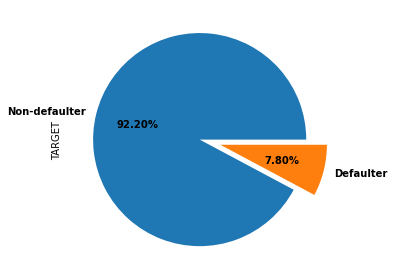

In [9]:
# Skewed class distribution with just the 80% filled features and
# the samples full for those features
dh['TARGET'].value_counts().plot.pie(
    autopct='%.2f%%',
    labels=['Non-defaulter', 'Defaulter'],
    textprops=dict(weight='bold'),
    explode=[0, .2]
)
plt.tight_layout()
plt.show()

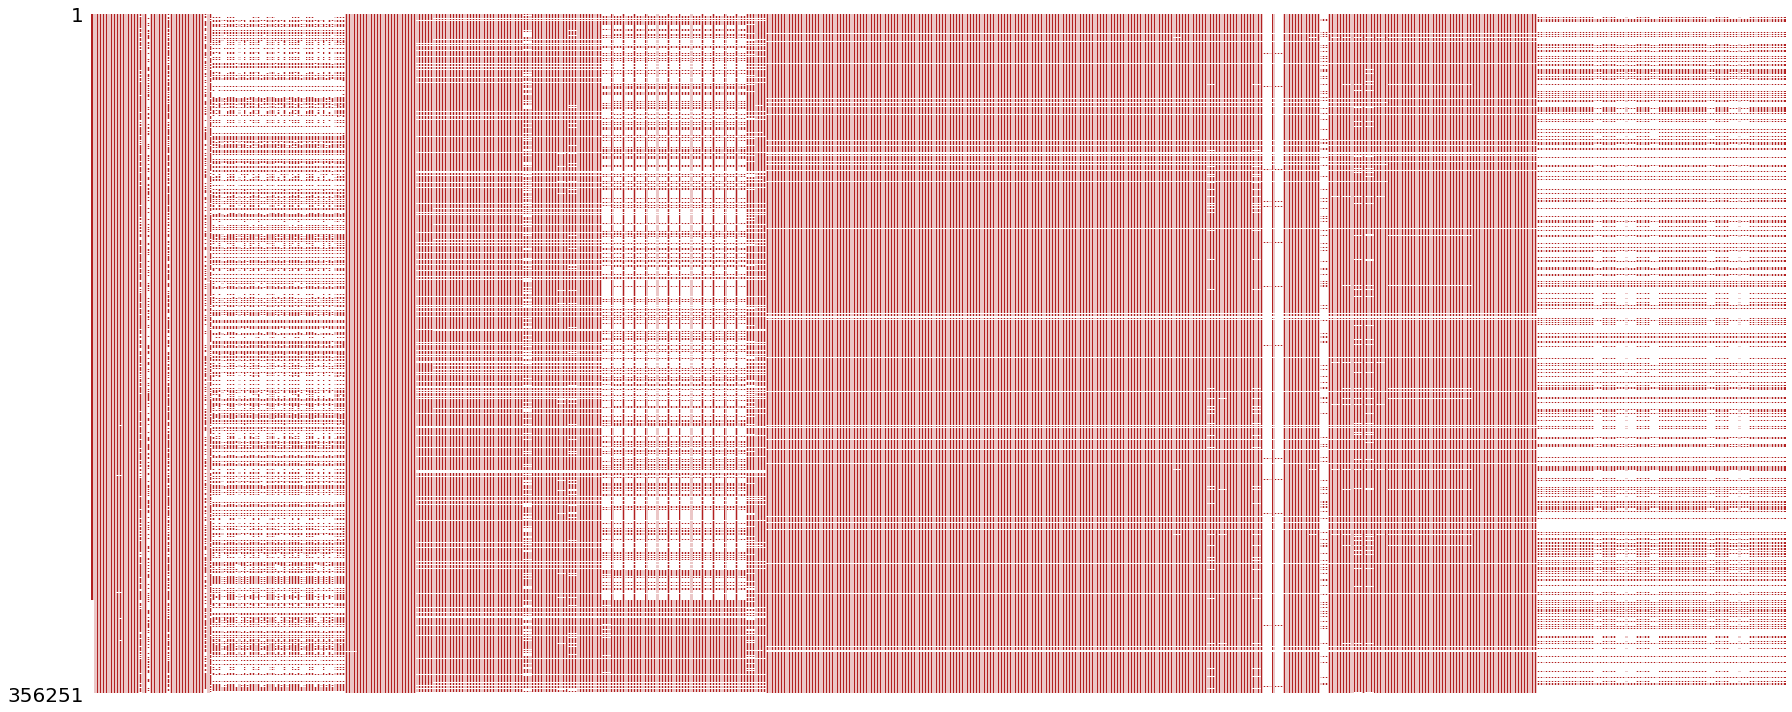

In [10]:
msno.matrix(
    df,
    sparkline=False,
    color=(.7, .13, .13) # firebrick
)
plt.tight_layout()
plt.show()

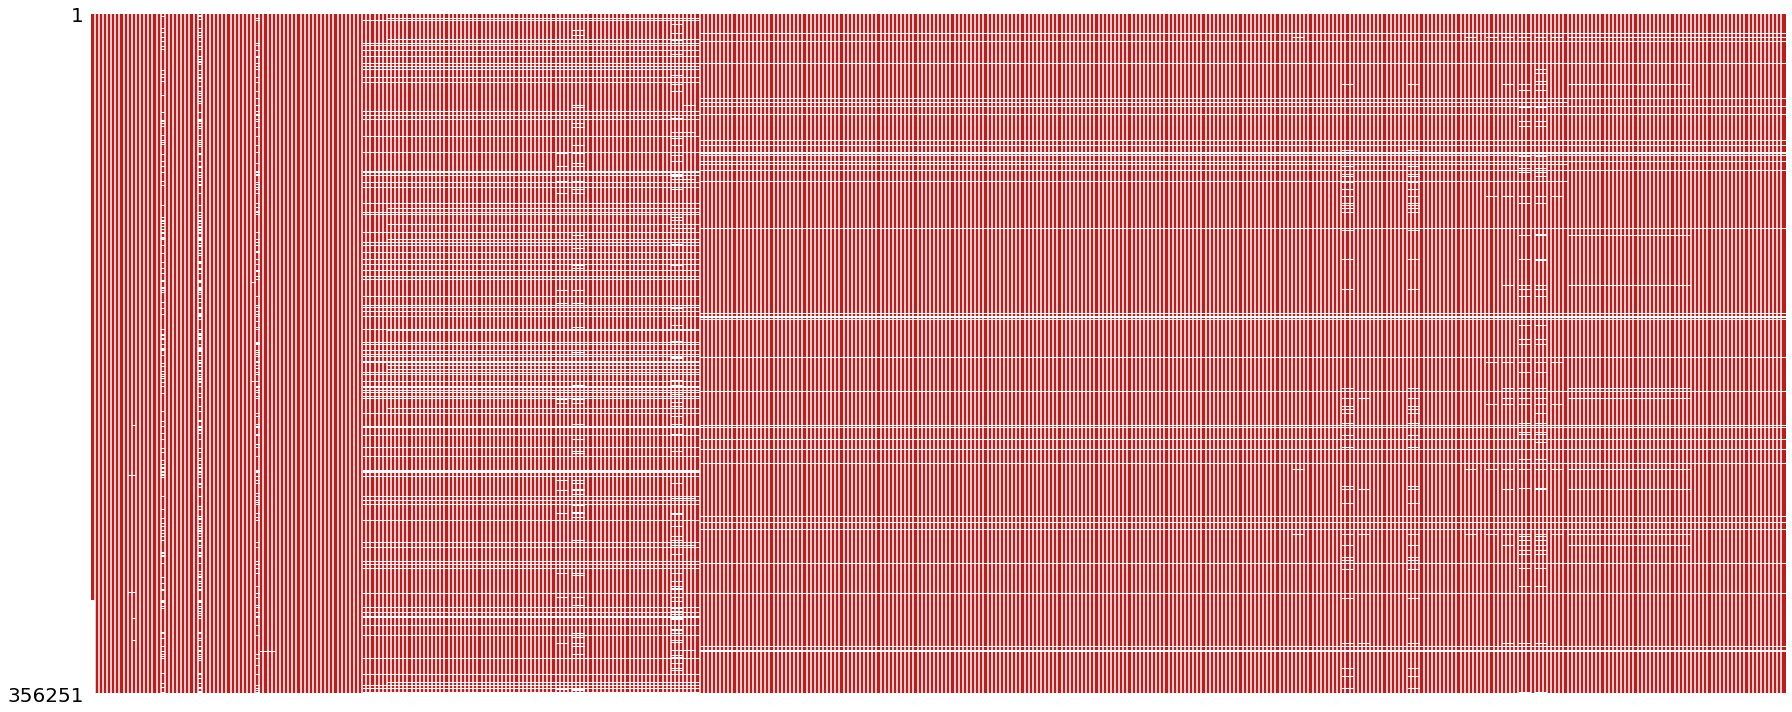

In [11]:
msno.matrix(
    dg,
    sparkline=False,
    color=(.7, .13, .13)
)
plt.tight_layout()
plt.show()

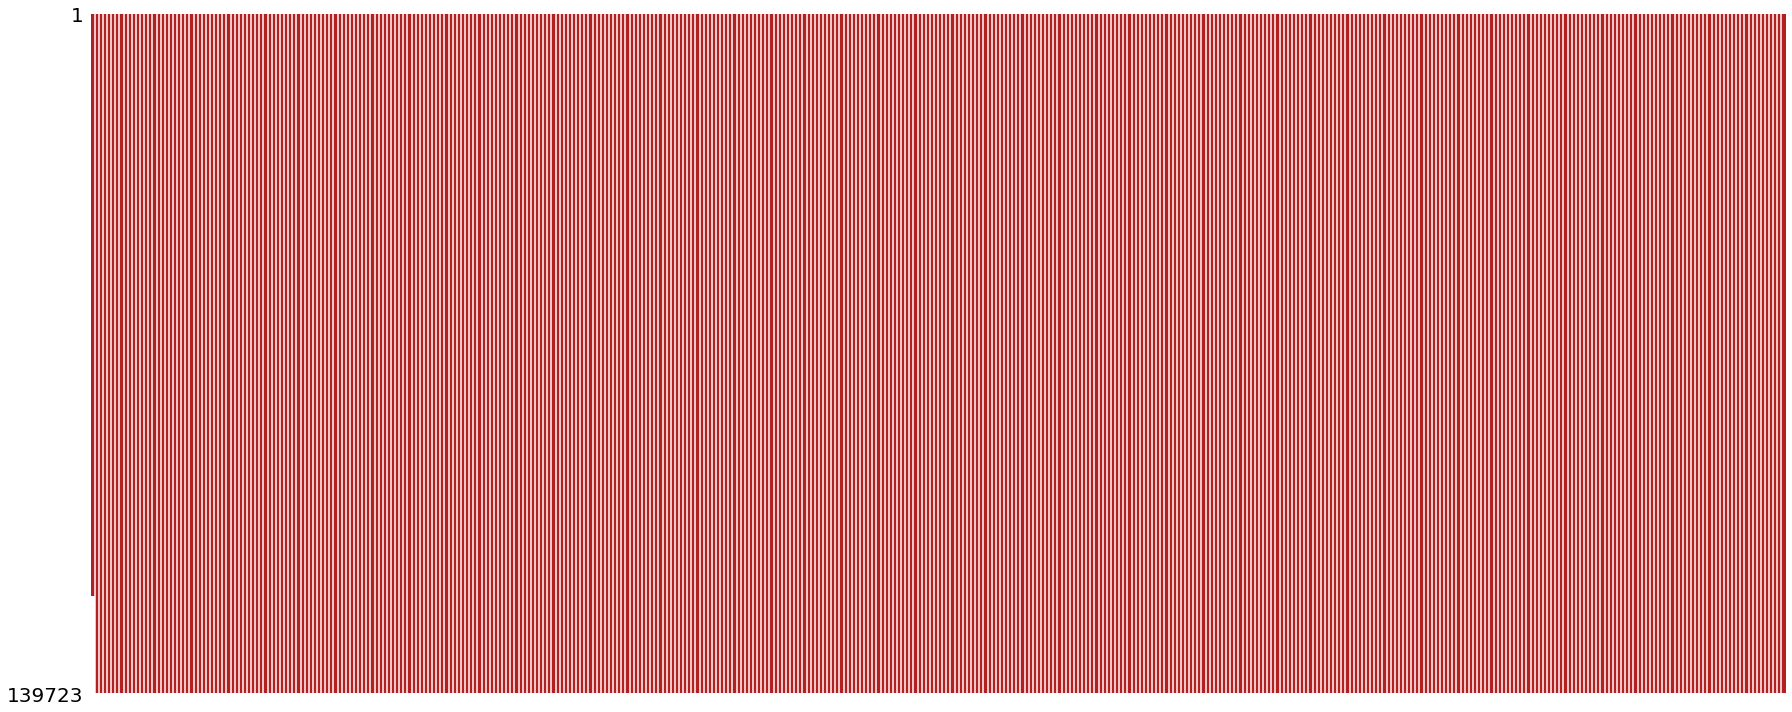

In [12]:
msno.matrix(
    dh,
    sparkline=False,
    color=(.7, .13, .13)
)
plt.tight_layout()
plt.show()

In [13]:
train_ratio = len(dh[dh['TARGET'].notna()]) / len(df[df['TARGET'].notna()])
test_ratio = len(dh[dh['TARGET'].isna()]) / len(df[df['TARGET'].isna()])

print(
    f'Reduced samples : original samples = {len(dh) / len(df):.3f}\n'
    f'Train ratio = reduced train samples : original train samples = {train_ratio:.3f}\n'
    f'Test ratio = reduced test samples : original test samples = {test_ratio:.3f}\n'
    f'Train ratio : test ratio = {train_ratio / test_ratio:.3f}\n'
    f'Original train samples : original samples = {df.TARGET.notna().sum() / len(df):.3f}\n'
    f'Original test samples : original samples = {df.TARGET.isna().sum() / len(df):.3f}\n'
    f'Reduced train samples : reduced samples = {dh.TARGET.notna().sum() / len(dh):.3f}\n'
    f'Reduced test samples : reduced samples = {dh.TARGET.isna().sum() / len(dh):.3f}'
)

Reduced samples : original samples = 0.392
Train ratio = reduced train samples : original train samples = 0.390
Test ratio = reduced test samples : original test samples = 0.408
Train ratio : test ratio = 0.954
Original train samples : original samples = 0.863
Original test samples : original samples = 0.137
Reduced train samples : reduced samples = 0.858
Reduced test samples : reduced samples = 0.142


In [14]:
dh.columns.to_series().reset_index(drop=True)

0                          TARGET
1              NAME_CONTRACT_TYPE
2                     CODE_GENDER
3                    FLAG_OWN_CAR
4                 FLAG_OWN_REALTY
                  ...            
407       IP_DAYS_INSTALMENT_mean
408     IP_DAYS_ENTRY_PAYMENT_max
409     IP_DAYS_ENTRY_PAYMENT_min
410    IP_DAYS_ENTRY_PAYMENT_mean
411                      IP_COUNT
Length: 412, dtype: object

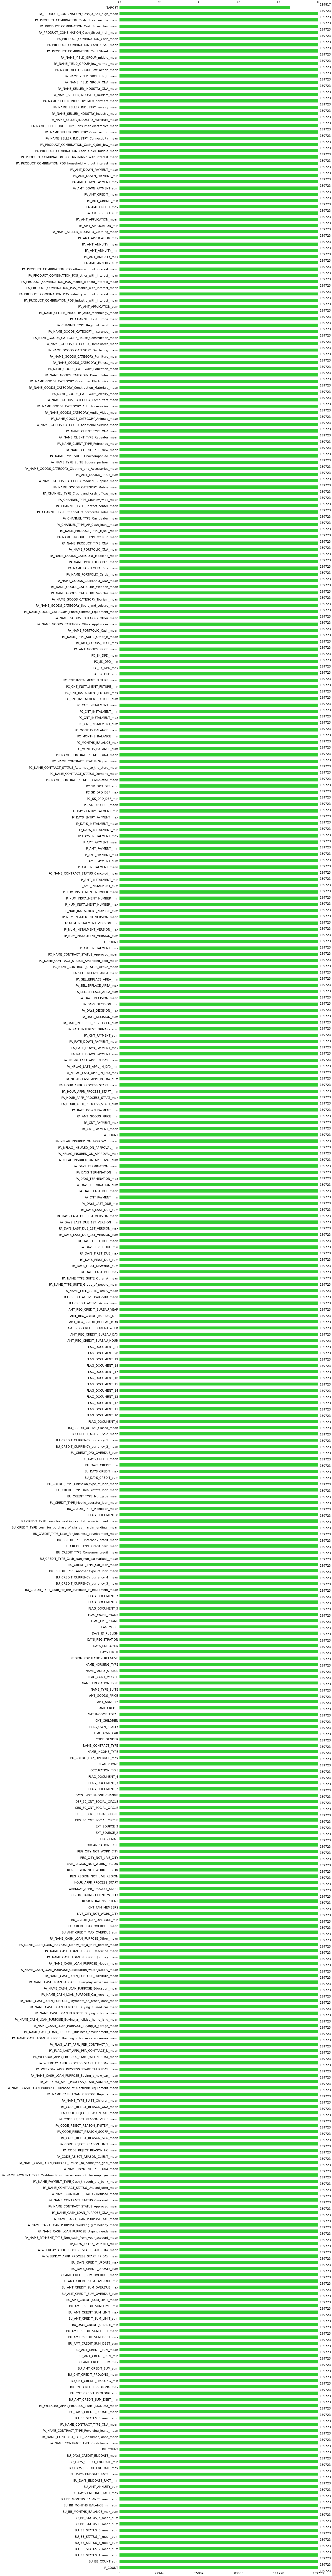

In [15]:
msno.bar(
    dh,
    sort='descending',
    color='limegreen'
)
plt.tight_layout()
plt.show()

In [16]:
df = dh

del dg, dh
gc.collect()

# df.to_csv('data/fulfilled_data.csv')

## Preprocessor

In [17]:
preprocessor = make_column_transformer(
    (
        StandardScaler(),
        make_column_selector(dtype_include=np.number)
    ),
    (
        OneHotEncoder(handle_unknown='ignore'),
        make_column_selector(dtype_include='object')
    )
)
# Display the preprocessor's diagram
preprocessor

# Classement des variables impactantes
# p-valeurs des indicateurs
# calcul odds ratio
# Shap
# interprétabilité de la qualité
# interprétabilité standarde des features


ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000010FAA893A00>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000010FAA893C70>)])

## Preprocessing

In [18]:
# Divide in training/validation and test data
df_train = df[df['TARGET'].notna()]
df_test = df[df['TARGET'].isna()]
# Divide in target/variables
y = df_train['TARGET']
X = df_train.drop(columns='TARGET')
# Split into train ans test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=df_train['TARGET'],
    random_state=0
)

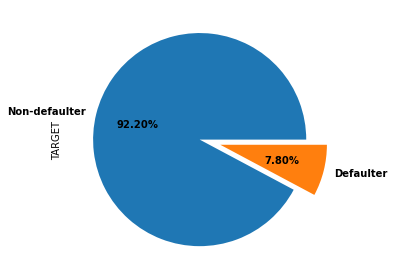

In [19]:
y_train.value_counts().plot.pie(
    autopct='%.2f%%',
    labels=['Non-defaulter', 'Defaulter'],
    textprops=dict(weight='bold'),
    explode=[0, .2]
)
plt.tight_layout()
plt.show()

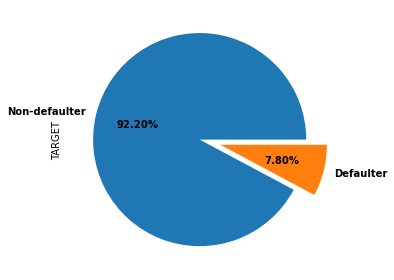

In [20]:
y_test.value_counts().plot.pie(
    autopct='%.2f%%',
    labels=['Non-defaulter', 'Defaulter'],
    textprops=dict(weight='bold'),
    explode=[0, .2]
)
plt.tight_layout()
plt.show()

In [21]:
# Preprocess both train and test sets
prep = preprocessor
prep.fit(X_train)

X_train_prep = pd.DataFrame(
    prep.transform(X_train),
    index=X_train.index,
    columns=prep.get_feature_names_out()
)
X_test_prep = pd.DataFrame(
    prep.transform(X_test),
    index=X_test.index,
    columns=prep.get_feature_names_out()
)

In [22]:
prep = preprocessor

df_prep = pd.DataFrame(
    prep.fit_transform(df.drop(columns='TARGET')),
    index=df.index,
    columns=prep.get_feature_names_out()
)
df_prep['TARGET'] = df['TARGET']
df_prep = reduce_memory_usage(df_prep)

# df_prep.to_csv('data/fulfilled_data_prep.csv')

## Rebalancing

### Undersampling

In [23]:
rus = RandomUnderSampler(random_state=0)
# Undersample the training set
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

In [24]:
print(
    f'Number of training samples: {len(X_train):,}\n'
    f'Number of reduced training samples: {len(X_train_us):,}\n'
    f'Decreased by {100 * (len(X_train) - len(X_train_us)) / len(X_train):.2f}%'
)

Number of training samples: 95,853
Number of reduced training samples: 14,948
Decreased by 84.41%


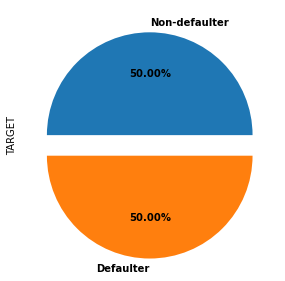

In [25]:
y_train_us.value_counts().plot.pie(
    autopct='%.2f%%',
    labels=['Non-defaulter', 'Defaulter'],
    textprops=dict(weight='bold'),
    explode=[0, .2]
)
plt.tight_layout()
plt.show()

### Oversampling

In [26]:
smote = SMOTENC(
    categorical_features=X_train.dtypes.eq('object'),
    random_state=0
)
# Oversample the training set
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

In [27]:
print(
    f'Number of training samples: {len(X_train):,}\n'
    f'Number of reduced training samples: {len(X_train_os):,}\n'
    f'Increased by {100 * (len(X_train_os) - len(X_train)) / len(X_train):.2f}%'
)

Number of training samples: 95,853
Number of reduced training samples: 176,758
Increased by 84.41%


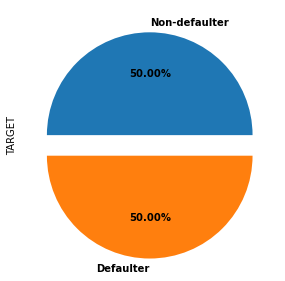

In [28]:
y_train_os.value_counts().plot.pie(
    autopct='%.2f%%',
    labels=['Non-defaulter', 'Defaulter'],
    textprops=dict(weight='bold'),
    explode=[0, .2]
)
plt.tight_layout()
plt.show()

# Logistic regression

  0%|          | 0/4 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Logistic regression
[CV] END  Fbeta_score: (test=0.037) ROC_AUC_score: (test=0.766) total time= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] END  Fbeta_score: (test=0.029) ROC_AUC_score: (test=0.756) total time= 1.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


[CV] END  Fbeta_score: (test=0.028) ROC_AUC_score: (test=0.764) total time= 1.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.3min remaining:    0.0s


[CV] END  Fbeta_score: (test=0.028) ROC_AUC_score: (test=0.762) total time= 1.2min
[CV] END  Fbeta_score: (test=0.032) ROC_AUC_score: (test=0.757) total time= 1.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.8min finished


               precision    recall  f1-score   support

Non-defaulter       0.92      1.00      0.96     22095
    Defaulter       0.49      0.03      0.05      1869

     accuracy                           0.92     23964
    macro avg       0.70      0.51      0.50     23964
 weighted avg       0.89      0.92      0.89     23964



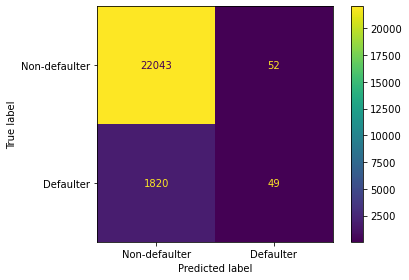

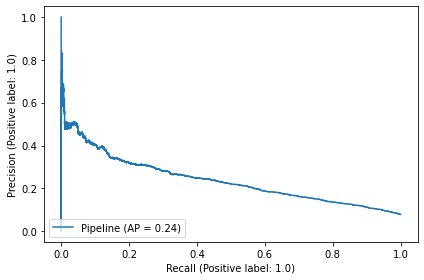

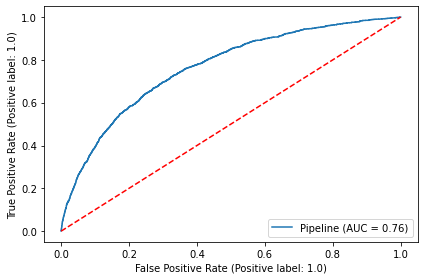

 25%|██▌       | 1/4 [06:28<19:26, 388.77s/it]

Logistic regression - done in 389s
Undersampled logistic regression


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END  Fbeta_score: (test=0.695) ROC_AUC_score: (test=0.745) total time=   7.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV] END  Fbeta_score: (test=0.690) ROC_AUC_score: (test=0.752) total time=   9.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.6s remaining:    0.0s


[CV] END  Fbeta_score: (test=0.691) ROC_AUC_score: (test=0.759) total time=   4.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.1s remaining:    0.0s


[CV] END  Fbeta_score: (test=0.686) ROC_AUC_score: (test=0.755) total time=   8.0s
[CV] END  Fbeta_score: (test=0.692) ROC_AUC_score: (test=0.766) total time=   5.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.0s finished


               precision    recall  f1-score   support

Non-defaulter       0.96      0.69      0.81     22095
    Defaulter       0.16      0.69      0.26      1869

     accuracy                           0.69     23964
    macro avg       0.56      0.69      0.53     23964
 weighted avg       0.90      0.69      0.76     23964



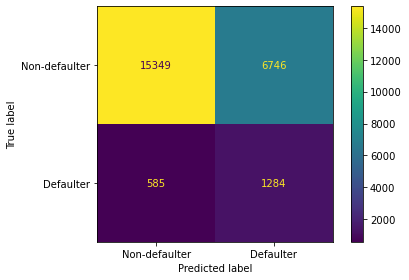

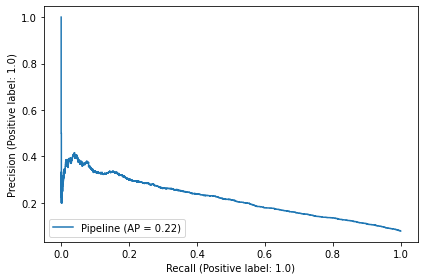

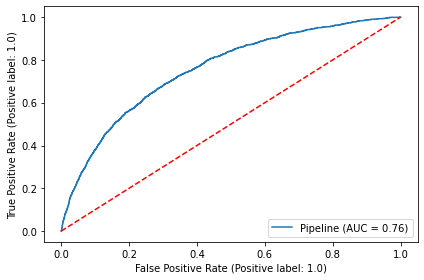

 50%|█████     | 2/4 [07:22<06:23, 191.93s/it]

Undersampled logistic regression - done in 50s
Oversampled logistic regression


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END  Fbeta_score: (test=0.641) ROC_AUC_score: (test=0.818) total time= 3.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s


[CV] END  Fbeta_score: (test=0.917) ROC_AUC_score: (test=0.949) total time= 5.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.1min remaining:    0.0s


[CV] END  Fbeta_score: (test=0.913) ROC_AUC_score: (test=0.948) total time= 3.7min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.7min remaining:    0.0s


[CV] END  Fbeta_score: (test=0.914) ROC_AUC_score: (test=0.948) total time= 3.5min
[CV] END  Fbeta_score: (test=0.914) ROC_AUC_score: (test=0.948) total time= 3.4min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 19.6min finished


               precision    recall  f1-score   support

Non-defaulter       0.94      0.84      0.89     22095
    Defaulter       0.15      0.34      0.21      1869

     accuracy                           0.80     23964
    macro avg       0.54      0.59      0.55     23964
 weighted avg       0.88      0.80      0.83     23964



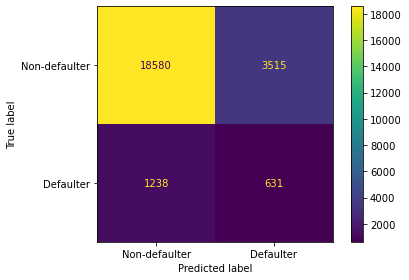

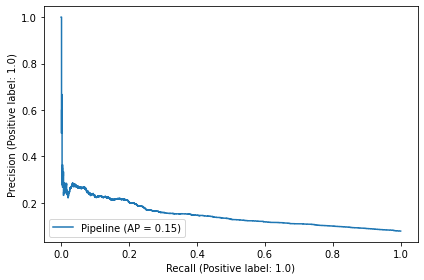

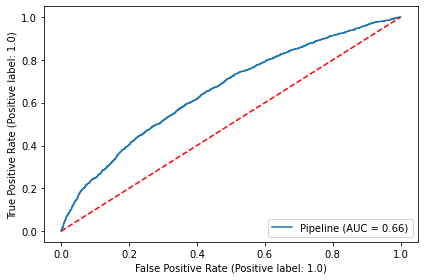

 75%|███████▌  | 3/4 [33:37<13:43, 823.10s/it]

Oversampled logistic regression - done in 1445s
Balanced logistic regression


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END  Fbeta_score: (test=0.668) ROC_AUC_score: (test=0.765) total time=  51.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.0s remaining:    0.0s


[CV] END  Fbeta_score: (test=0.646) ROC_AUC_score: (test=0.754) total time=  54.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV] END  Fbeta_score: (test=0.659) ROC_AUC_score: (test=0.762) total time=  45.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s


[CV] END  Fbeta_score: (test=0.666) ROC_AUC_score: (test=0.761) total time=  44.4s
[CV] END  Fbeta_score: (test=0.666) ROC_AUC_score: (test=0.758) total time=  47.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.0min finished


               precision    recall  f1-score   support

Non-defaulter       0.96      0.71      0.82     22095
    Defaulter       0.17      0.69      0.27      1869

     accuracy                           0.71     23964
    macro avg       0.56      0.70      0.54     23964
 weighted avg       0.90      0.71      0.77     23964



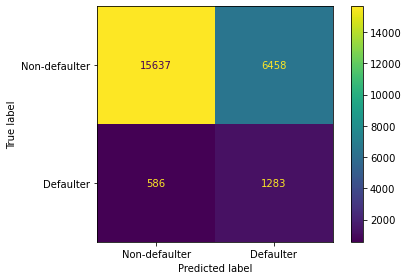

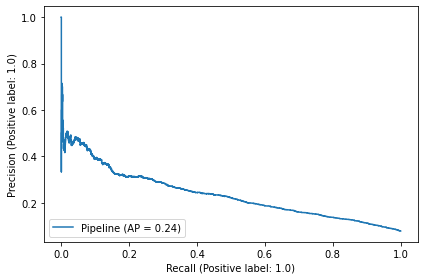

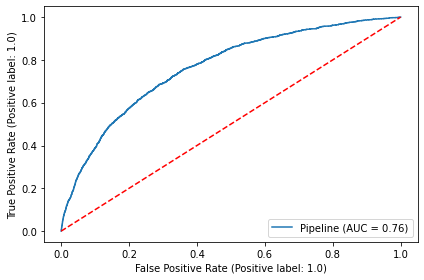

100%|██████████| 4/4 [38:44<00:00, 581.07s/it]

Balanced logistic regression - done in 307s


In [29]:
logistic_kernel = {
    'model': LogisticRegression(max_iter=10000),
    'model_bal': LogisticRegression(class_weight='balanced', max_iter=10000),
    'name': 'Logistic regression',
    'name_us': 'Undersampled logistic regression',
    'name_os': 'Oversampled logistic regression',
    'name_bal': 'Balanced logistic regression',
    'fit_models_path': 'models/logistic_fit_models.pkl',
    'cv_classification_reports_path': 'models/logistic_cv_classification_reports.pkl',
    'cv_results_path': 'models/logistic_cv_results.csv'
}

logistic_cv_results = cv_scorer(
    logistic_kernel,
    X_train, y_train,
    X_test, y_test
)

In [30]:
# logistic_cv_results = pd.read_csv('models/logistic_cv_results.csv')
logistic_cv_results

train_ROC_AUC_mean_score  test_ROC_AUC_score  \
none                           0.760980            0.511932   
undersampling                  0.755562            0.690840   
oversampling                   0.922080            0.589264   
balanced                       0.759907            0.697090   

               train_Fbeta_score  test_Fbeta_score  
none                    0.030926          0.026465  
undersampling           0.690949          0.665285  
oversampling            0.859515          0.333590  
balanced                0.661072          0.665754

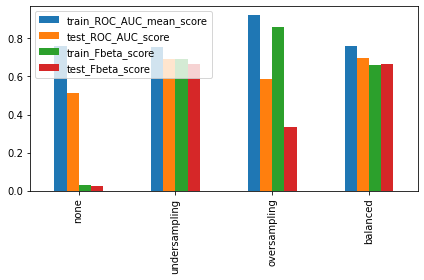

In [31]:
logistic_cv_results.plot.bar()
plt.tight_layout()
plt.show()

# Hyperparameter tuning

In [ ]:
# df = reduce_memory_usage(
#     pd.read_csv('data/full_data.csv', index_col='SK_ID_CURR')
# )

# fill_rate = .8
# print(
#     f'Number of 100% filled features: {len(df.columns[df.notna().all()])}\n'
#     f'Number of {fill_rate * 100}% filled features: {len(df.columns[df.notna().mean().ge(fill_rate)])}'
# )
# # Keep those features 80% filled
# dg = df[df.columns[df.notna().mean().ge(fill_rate)]]
# # Keep those samples with the 80% filled features full with the exception of the target
# dh = dg[dg.drop(columns='TARGET').notna().all(1)]

# df = dh
# del dg, dh
# gc.collect()

# # Divide in training/validation and test data
# df_train = df[df['TARGET'].notna()]
# df_test = df[df['TARGET'].isna()]
# # Divide in target/variables
# y = df_train['TARGET']
# X = df_train.drop(columns='TARGET')
# # Split into train ans test sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.2,
#     stratify=df_train['TARGET'],
#     random_state=0
# )

Number of 100% filled features: 52
Number of 80.0% filled features: 405


In [32]:
grid = GridSearchCV(    
    estimator=make_pipeline(
        make_column_transformer(
            (
                StandardScaler(),
                make_column_selector(dtype_include=np.number)
            ),
            (
                OneHotEncoder(handle_unknown='ignore'),
                make_column_selector(dtype_include='object')
            )
        ),
        LogisticRegression(
            class_weight='balanced',
            max_iter=10000
        )
    ),
    param_grid={
        'logisticregression__C': [.0001, .001, .01, 1, 10]
    },
    cv=5,
    scoring=fbeta_scorer,
    return_train_score=True,
    n_jobs=3,
    verbose=4,
    error_score='raise'
)
# Find the best regularization parameter C by grid searching
grid.fit(X_train, y_train)
best_index = grid.best_index_
std_score = grid.cv_results_['std_test_score'][best_index]
# Display the best model
print(grid.best_estimator_)
print(
    f'Mean cross-validation score of the best estimator for the balanced logistic regression:\n'
    f'Fbeta score = {grid.best_score_:.3f} ± {std_score:.3f}'
)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000010FFFA7AC40>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000010FFFA7AAF0>)])),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=10000))])
Mean cross-validation score of the best estimator for the balanced logistic regression:
Fbeta score = 0.663 ± 0.006


In [42]:
# pickle.dump(grid, open('models/logistic_cv_model.pkl', 'wb'))
# grid = pickle.load(open('models/logistic_cv_model.pkl', 'rb'))
grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028002D767C0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028002D76550>)])),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=10000))])

# Logistic feature importances

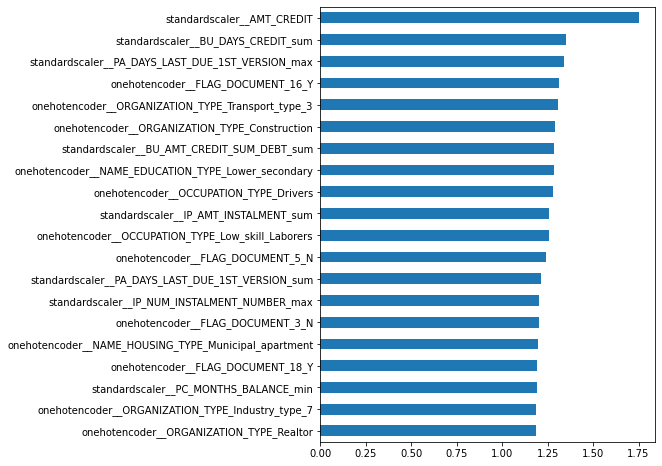

In [44]:
log_reg = grid.best_estimator_
# Calculate the importances explicitly
feature_importances = pd.Series(
    np.exp(log_reg.named_steps.logisticregression.coef_[0]),
    index=log_reg.named_steps.columntransformer.get_feature_names_out()
).rename('importance')
# feature_importances.nlargest(20).plot.barh(figsize=(6, 8)).invert_yaxis()
feature_importances.sort_values().tail(20).plot.barh(figsize=(6, 8))
plt.show()

# Dashboard data export

In [56]:
df = reduce_memory_usage(
    pd.read_csv(
        'data/fulfilled_data.csv',
        index_col='SK_ID_CURR'
    )
)
# Convert days to years
# NB These two new features will not affect the performance of the fit model
# since they will automatically not be taken into account
df.loc[:, 'AGE_YEARS'] = df['DAYS_BIRTH'].div(-365).apply(np.round, decimals=2)
df.loc[:, 'YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'].div(-365).apply(np.round, decimals=2)
# Get a sample of the modelling training data
X_train = df[df['TARGET'].notna()].sample(6000, random_state=0)
# Get a sample of the modelling testing data
X_test = df[df['TARGET'].isna()].sample(100, random_state=0).drop(columns='TARGET')
# From the full preprocessed testing data just the same observations are needed
# in order to run the model
X_test_prep = reduce_memory_usage(
    pd.read_csv(
        'data/fulfilled_data_prep.csv',
        index_col='SK_ID_CURR'
    ).loc[X_test.index]
)
X_test_prep.drop(columns='TARGET', inplace=True)

In [58]:
X_train.to_csv('data/X_train.csv')
X_test.to_csv('data/X_test.csv')
X_test_prep.to_csv('data/X_test_prep.csv')